<a href="https://colab.research.google.com/github/sottohy/Sperm-Embryo-classification-models/blob/main/Sperm_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
import matplotlib.pyplot as plt
from tensorflow.keras import layers, models
from shutil import copyfile, move
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import shutil
import random

img_width, img_height = 130, 130
batch_size = 64




es_callback = tf.keras.callbacks.EarlyStopping(patience=15, verbose=1,  restore_best_weights=True,monitor="val_accuracy")
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(factor=0.1, patience=15, verbose=1)



TypeError: api_export.__init__() got an unexpected keyword argument 'metaclass'

In [ ]:
# Paths to the data folders on Google Drive
good_sperm_path = "/content/drive/MyDrive/GP/sperm-morphological-quality/Sperm-Data/HighQualitySperm-Labeled/GoodSperm"
bad_sperm_path = "/content/drive/MyDrive/GP/sperm-data/bad500"

# Destination paths for training and testing data
base_path = "/content/drive/MyDrive/GP/train-test"
train_path = os.path.join(base_path, "training_data")
test_path = os.path.join(base_path, "testing_data")

# Create training and testing directories
os.makedirs(train_path, exist_ok=True)
os.makedirs(test_path, exist_ok=True)

def copy_data_with_structure(source_path, destination_path, split_ratio):
    files = os.listdir(source_path)

    # Calculate split index
    split_index = int(len(files) * split_ratio)

    # Create folders for Good and bad in training and testing
    for folder in ["Good", "bad"]:
        os.makedirs(os.path.join(destination_path, folder), exist_ok=True)

    # Print debug information
    print("Source Path:", source_path)
    print("Destination Path:", destination_path)
    print("Files:", len(files))
    print("Split Index:", split_index)

    # Copy images to destination paths
    for file in files[:split_index]:
        src_file = os.path.join(source_path, file)
        dst_folder = "Good" if "GoodSperm" in source_path else "bad" if "bad500" in source_path else None
        if dst_folder is not None:
            dst_file = os.path.join(destination_path, dst_folder, file)
            shutil.copy(src_file, dst_file)
            print(f"Copying {file} to {dst_folder}")


copy_data_with_structure(good_sperm_path, train_path, split_ratio=0.9)
copy_data_with_structure(good_sperm_path, test_path, split_ratio=0.1)

# # Copy data for bad500
copy_data_with_structure(bad_sperm_path, train_path, split_ratio=0.9)
copy_data_with_structure(bad_sperm_path, test_path, split_ratio=0.1)



Source Path: /content/drive/MyDrive/GP/sperm-morphological-quality/Sperm-Data/HighQualitySperm-Labeled/GoodSperm
Destination Path: /content/drive/MyDrive/GP/train-test/training_data
Files: 486
Split Index: 437
Copying 2017a_99_199_23146_23873.png to Good
Copying 2017a_99_199_11423_1815.png to Good
Copying 2017a_99_199_2113_7597.png to Good
Copying 2017a_99_99_17335_12430.png to Good
Copying 2017a_99_199_17804_18574.png to Good
Copying 2017a_99_99_24952_6859.png to Good
Copying 2017a_99_99_24577_7279.png to Good
Copying 2017b_199_99_15229_29074.png to Good
Copying 2017b_99_199_15502_21338.png to Good
Copying 2017a_99_99_8098_20904.png to Good
Copying 2017b_99_199_18885_10712.png to Good
Copying 2017b_299_99_12711_14790.png to Good
Copying 2017b_199_99_10901_3688.png to Good
Copying 2017b_99_199_17593_9872.png to Good
Copying 2017b_199_199_12514_19247.png to Good
Copying 2017b_199_99_7468_17610.png to Good
Copying 2017a_99_99_2450_3741.png to Good
Copying 2017b_299_99_19279_12997.png to 

In [ ]:
base_path = "/content/drive/MyDrive/GP/train-test"
train_path = os.path.join(base_path, "training_data")
test_path = os.path.join(base_path, "testing_data")

local_train_path = "/content/local_dataset11/train"
local_test_path = "/content/local_dataset11/test"


os.makedirs(local_train_path, exist_ok=True)
os.makedirs(local_test_path, exist_ok=True)

def copy_data(source_path, destination_path):
    files = os.listdir(source_path)

    # Create the destination path if it doesn't exist
    os.makedirs(destination_path, exist_ok=True)

    # Copy files to destination paths
    for file in files:
        src_file = os.path.join(source_path, file)
        dst_file = os.path.join(destination_path, file)

        # Check if the source is a directory
        if os.path.isdir(src_file):
            # Recursively copy the directory
            copy_data(src_file, dst_file)
        else:
            # Copy the file
            shutil.copy(src_file, dst_file)

# Copy data for training
copy_data(train_path, local_train_path)

# Copy data for testing
copy_data(test_path, local_test_path)


In [ ]:
datagen = ImageDataGenerator(
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='constant',
    cval=0.,
    rescale=1./255,
    validation_split=0.1,  # Change validation_split to 10%
    width_shift_range=0.2,
    height_shift_range=0.2
)
# Create generators for training, validation, and test sets
train_generator = datagen.flow_from_directory(
    "/content/local_dataset11/train",
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='binary',
    subset='training',
    shuffle=True
)

validation_generator = datagen.flow_from_directory(
    "/content/local_dataset11/train",
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='binary',
    subset='validation',
    shuffle=True
)

test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
   "/content/local_dataset11/test",
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='binary',
    shuffle=False
)




Found 803 images belonging to 2 classes.
Found 88 images belonging to 2 classes.
Found 98 images belonging to 2 classes.


In [ ]:
from tensorflow.keras.layers import BatchNormalization

model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(130, 130, 3)))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))



model.compile(optimizer='Nadam', loss='binary_crossentropy', metrics=['accuracy'])


history = model.fit(train_generator,
                    epochs=100,
                     callbacks=[es_callback, reduce_lr],
                     validation_data=validation_generator,
                     verbose=1)
test_loss, test_accuracy = model.evaluate(test_generator)

print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

# !pip install tensorflow-addons


# import tensorflow_addons as tfa
# adamw_optimizer = tfa.optimizers.AdamW(weight_decay=1e-4)

# model.compile(optimizer=adamw_optimizer, loss='binary_crossentropy', metrics=['accuracy'])


# history = model.fit(train_generator,
#                     epochs=100,
#                     callbacks=[es_callback, reduce_lr],
#                     validation_data=validation_generator,
#                     verbose=1)

# test_loss, test_accuracy = model.evaluate(test_generator)

# print(f"Test Loss: {test_loss}")
# print(f"Test Accuracy: {test_accuracy}")



# from tensorflow.keras.layers import BatchNormalization,AveragePooling2D

# model = Sequential()

# # Convolutional layers with 'SAME' padding
# model.add(Conv2D(64, (3, 3), activation='relu', input_shape=(224, 224, 3)))
# model.add(Conv2D(64, (3,3), activation='relu'))
# model.add(MaxPooling2D((2, 2)))

# model.add(Conv2D(128, (3, 3), activation='relu'))
# model.add(Conv2D(128, (3, 3), activation='relu'))
# model.add(MaxPooling2D((2, 2)))

# model.add(Conv2D(128, (3, 3), activation='relu'))
# model.add(MaxPooling2D((2, 2)))

# model.add(Conv2D(256, (3, 3), activation='relu'))
# model.add(Conv2D(256, (3, 3), activation='relu'))
# model.add(MaxPooling2D((2, 2)))

# model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
# model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
# model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))

# # Remove the last MaxPooling2D layer
# model.add(AveragePooling2D((2, 2)))

# model.add(Flatten())
# model.add(Dense(128, activation='relu'))
# model.add(Dropout(0.5))
# model.add(Dense(128, activation='relu'))
# model.add(Dropout(0.5))
# model.add(Dense(1, activation='sigmoid'))




# model.compile(optimizer='Adam', loss='binary_crossentropy', metrics=['accuracy'])


# history = model.fit(train_generator,
#                     epochs=100,
#                     callbacks=[es_callback, reduce_lr],
#                     validation_data=validation_generator,
#                     verbose=1)

# test_loss, test_accuracy = model.evaluate(test_generator)

# print(f"Test Loss: {test_loss}")
# print(f"Test Accuracy: {test_accuracy}")


Epoch 1/100
26/26 [==============================] - 7s 160ms/step - loss: 0.7600 - accuracy: 0.6027 - val_loss: 0.9086 - val_accuracy: 0.4545 - lr: 0.0010
Epoch 2/100
26/26 [==============================] - 6s 217ms/step - loss: 0.5636 - accuracy: 0.7273 - val_loss: 0.7838 - val_accuracy: 0.4659 - lr: 0.0010
Epoch 3/100
26/26 [==============================] - 4s 157ms/step - loss: 0.5064 - accuracy: 0.7846 - val_loss: 0.8687 - val_accuracy: 0.5227 - lr: 0.0010
Epoch 4/100
26/26 [==============================] - 4s 159ms/step - loss: 0.4186 - accuracy: 0.8394 - val_loss: 0.6464 - val_accuracy: 0.6023 - lr: 0.0010
Epoch 5/100
26/26 [==============================] - 5s 209ms/step - loss: 0.4182 - accuracy: 0.8319 - val_loss: 0.8398 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 6/100
26/26 [==============================] - 4s 167ms/step - loss: 0.3801 - accuracy: 0.8580 - val_loss: 0.6640 - val_accuracy: 0.5909 - lr: 0.0010
Epoch 7/100
26/26 [==============================] - 5s 199ms/st

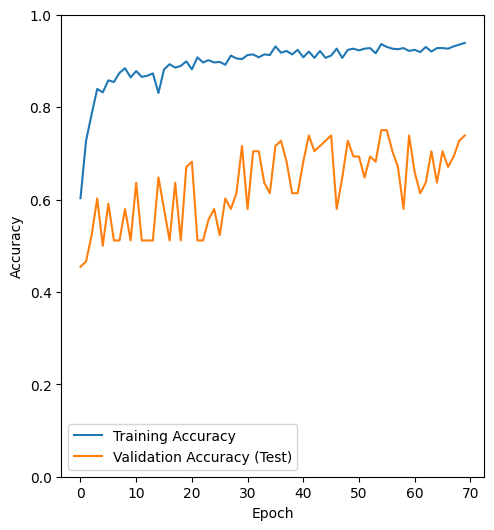

Test Accuracy: 77.55%


In [ ]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy (Test)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.ylim([0, 1])


plt.show()
print(f"Test Accuracy: {round(test_accuracy*100,2)}%")

3/3 [==============================] - 0s 122ms/step


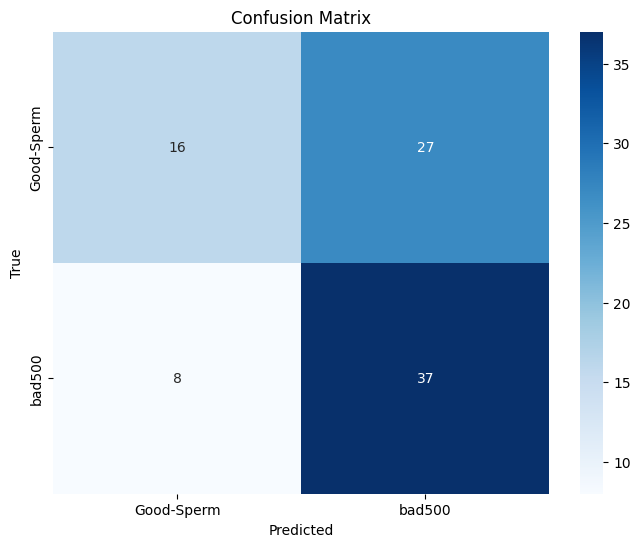

Classification Report:
               precision    recall  f1-score   support

  Good-Sperm       0.67      0.37      0.48        43
      bad500       0.58      0.82      0.68        45

    accuracy                           0.60        88
   macro avg       0.62      0.60      0.58        88
weighted avg       0.62      0.60      0.58        88



In [ ]:
y_pred = model.predict(validation_generator)
y_pred_classes = np.round(y_pred)

y_true = validation_generator.classes


conf_matrix = confusion_matrix(y_true, y_pred_classes)


plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=["Good-Sperm", "bad500"], yticklabels=["Good-Sperm", "bad500"])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

class_report = classification_report(y_true, y_pred_classes, target_names=["Good-Sperm", "bad500"])
print("Classification Report:\n", class_report)



plt.show()